In [73]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
import imutils
import scipy.stats as stats

In [74]:
## Ne garder que les images non câblées

liste_non_cablees=[]
dossier="ModulePictures"

for fichier in os.listdir(dossier):
    if os.path.isfile(os.path.join(dossier, fichier)) and ("Reception" in os.path.basename(fichier)):
        liste_non_cablees.append(str(dossier + "/"+ os.path.basename(fichier)))

## Ne garder que les images câblées

liste_cablees=[]
dossier="ModulePictures"

for fichier in os.listdir(dossier):
    if os.path.isfile(os.path.join(dossier, fichier)) and ("AfterBonding" in os.path.basename(fichier)):
        liste_cablees.append(str(dossier + "/"+ os.path.basename(fichier)))


In [75]:
def mires(img_input, draw = False):
    
    assert img_input is not None, "file could not be read, check with os.path.exists()"

    img = cv.cvtColor(img_input,cv.COLOR_BGR2GRAY)

    (height,length) = img.shape

    ## TODO : changer cette extraction à la main par quelque chose d'automatisé
    sliceparams = [(100, 400, 300, 600, 1),  
                   (-400, -100, 300, 600, 1),
                   (3800, 4200, 500, 800, 2), 
                   (100, 400, -600,-300, 1), 
                   (-400, -100, -600, -300, 1), 
                   (3800, 4200, -800, -500, 2)]

    cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)

    centers = []

    for (beg1, end1, beg2, end2, nbmires) in sliceparams :
        mask = img[beg1:end1, beg2:end2]

        #Blur pour réduire le bruit
        mask = cv.medianBlur(mask,5)
        #Fonction qui détecte les cercles.
        circles = cv.HoughCircles(mask,cv.HOUGH_GRADIENT,1,minDist = 100,
                                    param1=50,param2=20,minRadius=20 ,maxRadius=30)

        if circles is not None:
            circles = np.int16(np.around(circles))
            for i in circles[0,:nbmires]:
                
                centers.append([i[0]+beg2%length,i[1]+beg1%height])

                #Dessin des cercles
                if draw :
                    cv.circle(cimg,(i[0]+beg2%length,i[1]+beg1%height),i[2],(0,255,0),20)
                    cv.circle(cimg,(i[0]+beg2%length,i[1]+beg1%height),2,(0,0,255),3)

    if draw :
        plt.imshow(cimg)
        plt.show()

    assert len(centers) == 8, "Mires manquantes"

    return np.array(centers)

In [165]:
#Détection à la main de la frontière supérieure verte :

def horiz_pcb(img) :

    lower_bound = np.array([0, 40, 0])
    upper_bound = np.array([40,110,110])
    bwimg = cv.inRange(img, lower_bound, upper_bound)
    imagemask_green = cv.medianBlur(bwimg,25)

    middle = img.shape[1]//2

    top_contour = np.zeros((1000,2),dtype=np.int32)
    bot_contour = np.zeros((1000,2),dtype=np.int32)

    for j in range(middle - 2000, middle - 1500) :

        top_contour[(j - middle + 2000)] = [j,min(np.where(imagemask_green[:,j] == 255)[0])]
        bot_contour[(j - middle + 2000)] = [j,max(np.where(imagemask_green[:,j] == 255)[0])]

    for j in range(middle + 1500, middle + 2000) : 

        top_contour[(j - middle-1000)] = [j,min(np.where(imagemask_green[:,j] == 255)[0])]
        bot_contour[(j - middle-1000)] = [j,max(np.where(imagemask_green[:,j] == 255)[0])]

    slopes = [stats.linregress(top_contour[:,0], top_contour[:,1]).slope, stats.linregress(bot_contour[:,0], bot_contour[:,1]).slope]
    intercepts = [int(stats.linregress(top_contour[:,0], top_contour[:,1]).intercept), int(stats.linregress(bot_contour[:,0], bot_contour[:,1]).intercept)]

    spacing = bot_contour[:,1]-top_contour[:,1]

    #Pour dessiner les résultats et éventuellement ajuster la zone de repérage de bord

    # for i in range(len(top_contour)):
    #     cv.circle(img,(top_contour[i][0], top_contour[i][1]),15,(255,0,0),15)
    #     cv.circle(img,(bot_contour[i][0], bot_contour[i][1]),15,(255,0,0),15)

    # plt.imshow(img)
    # plt.show()

    return slopes,intercepts,np.mean(spacing)

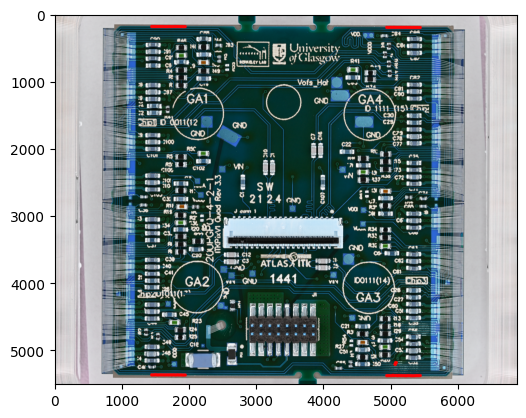

([np.float64(0.0037381423172470904), np.float64(0.0009458233228600898)],
 [180, 5366],
 np.float64(5176.648))

In [148]:
horiz_pcb(cv.imread(liste_cablees[13]))

In [78]:
## Fonctions utiles

def tourner_image(image, pente):
    return imutils.rotate(image, np.arctan(pente))

def trouver_la_paire(fichier, dossier):
    bname=os.path.basename(fichier)
    if "AfterBonding" in bname:
        name=bname[:bname.find("AfterBonding")]
        for f in os.listdir(dossier):
            if "Reception" in os.path.basename(f):
                if os.path.basename(f)[:os.path.basename(f).find("Reception")]==name:
                    return f
    elif "Reception" in bname:
        name=bname[:bname.find("Reception")]
        for f in os.listdir(dossier):
            if "AfterBonding" in os.path.basename(f):
                if os.path.basename(f)[:os.path.basename(f).find("AfterBonding")]==name:
                    return f
    return "Pas de paire"

In [79]:
trouver_la_paire(liste_cablees[0],"ModulePictures")

'20UPGM23210250_PPPV2_45_Reception_Glo_NoLight_AfterClean.jpg'

In [80]:
def afficher(img) :
    cv.imshow("Image", img)
    cv.waitKey(0)
    cv.destroyAllWindows()

In [141]:
def afficher_points(img, mires_img1):
    img_copy = img.copy()
    for centre in mires_img1 :
        cv.circle(img_copy, (centre[0],centre[1]),15,(255,0,0),15)

    plt.imshow(img_copy)
    plt.show()

In [81]:
def rotation_mires(path): #prend en argument une image cablée, renvoie la rotation des mires.
    img_cablee = cv.imread(path)
    path_non_cablee = 'ModulePictures/' + trouver_la_paire(path,"ModulePictures")
    img_non_cablee = cv.imread(path_non_cablee)

    relative_slope = horiz_pcb(img_non_cablee)[0] - mires(img_non_cablee)[1]

    return tourner_image(img_cablee, horiz_pcb(img_cablee)[0] - relative_slope)

In [82]:
def trouve_cercle(img):
    
    assert img is not None, "file could not be read, check with os.path.exists()"

    (height,width) = img.shape

    img = img[height//8 : height//3, width//2 - 500 : width//2 + 500]

    img = cv.medianBlur(img,5)
    cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)

    circles = cv.HoughCircles(img,cv.HOUGH_GRADIENT,1,1e5,
                                param1=50,param2=30,minRadius=200,maxRadius=400)

    circles = np.uint16(np.around(circles))

    return circles[0,0][:2] + [width//2 - 500, height//8]

In [83]:
def trouve_ligne(img):

    (height,width) = img.shape

    img = img[height//3 : height//2, width//2 - 200 : width//2 + 200]

    img = cv.medianBlur(img,3)

    dst = cv.Canny(img, 50, 200, None, 3)

    lines = cv.HoughLines(dst, 1, np.pi / 360, 220, None, 0, 0,min_theta=-np.pi/8, max_theta=np.pi/8)

    lines = lines[:2,0,:]

    median_line = np.mean(lines,axis=0)

    return median_line, width//2 - 200, height//2
    #return ([int(lines[0,0,0]/np.cos(lines[0,0,1]) + width//2 - 200), height//2], [int(lines[1,0,0]/np.cos(lines[1,0,1]) + width//2 - 200), height//2])

In [84]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

In [85]:
def matrice_psg(img):
    [rho,theta],alpha,beta = trouve_ligne(cv.cvtColor(img,cv.COLOR_BGR2GRAY))
    [_,c],[_,d], dilatation = horiz_pcb(img) #Droite horizontale y = cx + d

    if theta==0 :
        pt_intersection = (int(alpha + rho), int(c*(alpha+rho) + d))
        vert_vector = np.array([0,1])
    else :

        a = -(np.cos(theta)/np.sin(theta))
        b = rho/np.sin(theta) + beta - alpha/np.tan(theta) #Droite verticale y = ax + b

        x = int((d-b)/(a-c))
        pt_intersection = (x,int(a*x+b))

        vert_vector = normalize(np.array([1,a]))
    
    horiz_vector = normalize(np.array([1,c]))

    matrice_passage = np.transpose(np.array([horiz_vector,vert_vector])) #Matrice de passage de l'espace normal à l'espace qui nous intéresse

    return matrice_passage, pt_intersection, dilatation
    

In [ ]:
path = liste_cablees[13]
def mires_cablees(path):
    img_cablee = cv.imread(path)
    img_non_cablee = cv.imread('ModulePictures/' + trouver_la_paire(path,"ModulePictures"))

    centres_mires = mires(img_non_cablee)

    ## ON TROUVE DANS L'ESPACE DE BASE L'EXPRESSION DE LA POSITION DES MIRES

    matrice_passage_init, pt_intersection_init, dilatation_init = matrice_psg(img_non_cablee)

    ## ON RETROUVE L'ESPACE ASSOCIE A LA CARTE PCB SUR L'IMAGE CABLEE

    matrice_passage_dst, pt_intersection_dst, dilatation_dst = matrice_psg(img_cablee)

    dilatation = (dilatation_dst)/dilatation_init ##XXX DILATATION IMPRECISE A CHANGER (c'est ce qui fait tout foirer.)

    nouveaux_centres = []
    for centre in centres_mires:
        nouveaux_centres.append(np.dot(np.linalg.inv(matrice_passage_dst),dilatation*np.dot(matrice_passage_init,centre - pt_intersection_init)) + pt_intersection_dst)

    nouveaux_centres = np.array(nouveaux_centres).astype(np.int16)

    return nouveaux_centres


In [163]:
def repere_absolu(path):
    centres = mires_cablees(path)

    print(centres)

    a = sum([(centres[i+4,0]-centres[i,0])/(centres[i+4,1]-centres[i,1]) for i in range(0,4)])/4 #Pente horizontale moyenne
    origine = np.mean(centres,axis=0).astype(np.int16)

    mat_passage = 1/np.sqrt(a**2 + 1) * np.array([[1,-a],[a,1]])

    afficher_points(cv.imread(path),centres)

    return mat_passage, np.flip(origine) #Origine renvoyée en (i,j)

[[ 989  258]
 [ 998 5245]
 [1123 2805]
 [1123 2710]
 [5850  236]
 [5857 5226]
 [5726 2784]
 [5726 2690]]


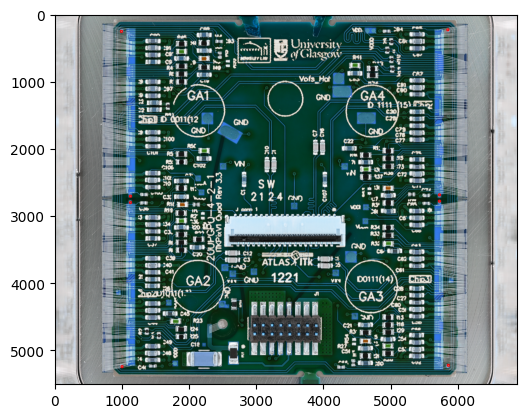

(array([[ 0.00431947,  0.99999067],
        [-0.99999067,  0.00431947]]),
 array([2744, 3424], dtype=int16))

In [166]:
path = liste_cablees[5]
repere_absolu(path)

In [162]:
## DATA IMAGE 1

## POSITIONS MIRES :
mire1 = [251, 927]
mire2 = [5234, 932]
mire3 = [2703, 1058]
mire4 = [2796, 1058]
mire5 = [247, 5788]
mire6 = [5230, 5788]
mire7 = [2700, 5659]
mire8 = [2793, 5659]

mires_img1 = np.array([mire1, mire2, mire3, mire4, mire5, mire6, mire7, mire8])

centre = np.mean(mires_img1, axis = 0).astype(np.int16)

spacing = 0.5*(np.linalg.norm(mires_img1[0]-mires_img1[5]) + np.linalg.norm(mires_img1[1]-mires_img1[4]))

a = sum([(mires_img1[i+4,0]-mires_img1[i,0])/(mires_img1[i+4,1]-mires_img1[i,1]) for i in range(0,4)])/4 #Pente horizontale moyenne

mat_passage = 1/np.sqrt(a**2 + 1) * np.array([[1,-a],[a,1]])

## PADS DU PCB
pad1 = [[220,1000],[230,1130]]
pad2 = [[246,1000],[256,1130]]
pad3 = [[270,1000],[280,1130]]
pad4 = [[296,1051],[308,1130]]
pad5 = [[322,1066],[334,1130]]
pad6 = [[323,1037],[359,1052]]
pad7 = [[402,1050],[453,1130]]
pad8 = [[469,1050],[551,1130]]
pad9 = [[566,1050],[615,1130]]
pad10 = [[749,1036],[785,1052]]
pad11 = [[773,1063],[786,1130]]
pad12 = [[799,1050],[813,1130]]
pad13 = [[825,1050],[839,1130]]
pad14 = [[851,1050],[863,1130]]
pad15 = [[877,1050],[890,1130]]
pad16 = [[903,1050],[915,1130]]
pad17 = [[929,1065],[941,1130]]
pad18 = [[932,1037],[967,1051]]
pad19 = [[1009,1050],[1060,1130]]
pad20 = [[1075,1050],[1157,1130]]
pad21 = [[1171,1050],[1220,1130]]
pad22 = [[1132,1078],[1135,1130]]
pad23 = [[1354,1078],[1369,1130]]
pad24 = [[1432,1079],[1447,1131]]
pad25 = [[1464,1079],[1479,1131]]
pad26 = [[1496,1079],[1511,1131]]
pad27 = [[1529,1079],[1544,1131]]
pad28 = [[1561,1079],[1576,1131]]
pad29 = [[1593,1079],[1608,1131]]
pad30 = [[1758,1051],[1811,1131]]
pad31 = [[1824,1051],[1907,1131]]
pad32 = [[1920,1052],[1972,1132]]
pad33 = [[2014,1038],[2052,1052]]
pad34 = [[2041,1065],[2053,1132]]
pad35 = [[2065,1002],[2079,1132]]
pad36 = [[2090,1002],[2104,1132]]
pad37 = [[2128,1002],[2256,1051]]
pad38 = [[2366,1052],[2417,1132]]
pad39 = [[2431,1052],[2513,1132]]
pad40 = [[2528,1052],[2579,1132]]
pad41 = [[2651,1053],[2663,1131]]
pad42 = [[297,1000],[798,1024]]
pad43 = [[923,1000],[1297,1024]]
pad44 = [[1369,1038],[1710,1062]]
pad45 = [[1369,999],[2051,1025]]
pad46 = [[2284,1001],[2662,1025]]

pads = np.array([pad1,pad2,pad3,pad4,pad5,pad6,pad7,pad8,pad9,pad10,pad11,pad12,pad13,pad14,pad15,pad16,pad17,pad18,pad19,pad20,pad21,pad22,pad23,pad24,pad25,pad26,pad27,pad28,pad29,pad30,pad31,pad32,pad33,pad34,pad35,pad36,pad37,pad38,pad39,pad40,pad41,pad42,pad43,pad44,pad45,pad46])

pads_nouveau_repère = np.array([np.dot(mat_passage,pads[i]-np.array([centre,centre])) for i in range(46)]).astype(np.int16)

print(pads_nouveau_repère)


[[[-2525 -2359]
  [-2512 -2226]]

 [[-2499 -2359]
  [-2486 -2226]]

 [[-2475 -2359]
  [-2462 -2226]]

 [[-2449 -2308]
  [-2434 -2226]]

 [[-2423 -2293]
  [-2408 -2226]]

 [[-2422 -2322]
  [-2383 -2304]]

 [[-2343 -2309]
  [-2289 -2226]]

 [[-2276 -2309]
  [-2191 -2226]]

 [[-2179 -2309]
  [-2127 -2226]]

 [[-1996 -2323]
  [-1957 -2304]]

 [[-1972 -2296]
  [-1956 -2226]]

 [[-1946 -2309]
  [-1929 -2226]]

 [[-1920 -2309]
  [-1903 -2226]]

 [[-1894 -2309]
  [-1879 -2226]]

 [[-1868 -2309]
  [-1852 -2226]]

 [[-1842 -2309]
  [-1827 -2226]]

 [[-1816 -2294]
  [-1801 -2226]]

 [[-1813 -2322]
  [-1775 -2305]]

 [[-1736 -2309]
  [-1682 -2226]]

 [[-1670 -2309]
  [-1585 -2226]]

 [[-1574 -2309]
  [-1522 -2226]]

 [[-1613 -2281]
  [-1607 -2226]]

 [[-1391 -2281]
  [-1373 -2226]]

 [[-1312 -2280]
  [-1296 -2225]]

 [[-1280 -2280]
  [-1264 -2225]]

 [[-1248 -2280]
  [-1232 -2225]]

 [[-1215 -2280]
  [-1199 -2225]]

 [[-1183 -2280]
  [-1167 -2225]]

 [[-1151 -2280]
  [-1135 -2225]]

 [[ -986 -2308